In [1]:
! pip install albumentations==0.4.6
# 1. 라이브러리 임포트
# 2. 코랩 연결 부분
# 3. 클래스 , 함수 정의
# 4. 모델 초기화
# 5. train
# 6. test
# 7. 파일 저장

     |████████████████████████████████| 122kB 18.5MB/s 
     |████████████████████████████████| 952kB 29.3MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65163 sha256=e1d7e8c2a3b9e25969fb5e22d784479d36a30b9c3850485f03c3ab8f0d3021ab
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [177]:
def draw_keypoints(
    image: np.ndarray,
    keypoints: np.ndarray,
    edges: List[Tuple[int, int]] = None,
    keypoint_names: Dict[int, str] = None, 
    boxes: bool = True,
    dpi: int = 200
) -> None:
    """
    Args:
        image (ndarray): [H, W, C]
        keypoints (ndarray): [N, 3]
        edges (List(Tuple(int, int))): 
    """
    np.random.seed(42)
    colors = {k: tuple(map(int, np.random.randint(0, 255, 3))) for k in range(24)}

    if boxes:
        x1, y1 = min(keypoints[:, 0]), min(keypoints[:, 1])
        x2, y2 = max(keypoints[:, 0]), max(keypoints[:, 1])
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 100, 91), thickness=3)

    for i, keypoint in enumerate(keypoints):
        cv2.circle(
            image, 
            tuple(keypoint), 
            3,(255,0,0), thickness=3, lineType=cv2.FILLED)

        if keypoint_names is not None:
            cv2.putText(
                image, 
                f'{i}: {keypoint_names[i]}', 
                tuple(keypoint), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

    if edges is not None:
        for i, edge in enumerate(edges):
            cv2.line(
                image, 
                tuple(keypoints[edge[0]]), 
                tuple(keypoints[edge[1]]),
                colors.get(edge[0]), 3, lineType=cv2.LINE_AA)

    fig, ax = plt.subplots(dpi=dpi)
    ax.imshow(image)
    ax.axis('off')
    plt.show()
    keypoints = target_array
keypoint_names = {
    0: 'nose',
    1: 'left_eye',
    2: 'right_eye',
    3: 'left_ear', 
    4: 'right_ear', 
    5: 'left_shoulder', 
    6: 'right_shoulder',
    7: 'left_elbow', 
    8: 'right_elbow',
    9: 'left_wrist', 
    10: 'right_wrist',
    11: 'left_hip', 
    12: 'right_hip',
    13: 'left_knee', 
    14: 'right_knee',
    15: 'left_ankle', 
    16: 'right_ankle',
    17: 'neck', 
    18: 'left_palm', 
    19: 'right_palm', 
    20: 'spine2(back)',
    21: 'spine1(waist)', 
    22: 'left_instep',
    23: 'right_instep'
}

edges = [
    (0, 1), (0, 2), (2, 4), (1, 3), (6, 8), (8, 10), (9, 18),
    (10, 19), (5, 7), (7, 9), (11, 13), (13, 15), (12, 14),
    (14, 16), (15, 22), (16, 23), (20, 21), (5, 6), (5, 11),
    (6, 12), (11, 12), (17, 20), (20, 21), 
]
#draw_keypoints(np.array(train_image).transpose(1,2,0), keypoints, edges, keypoint_names, boxes=False, dpi=400)

In [2]:
-|import torch,gc
import torch.nn as nn
from torchvision.ops import MultiScaleRoIAlign
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import torchvision
import matplotlib.pyplot as plt
import cv2
import PIL
import PIL.Image
import numpy as np
import os
import pandas as pd
from typing import Tuple, List, Sequence, Callable, Dict
import albumentations as A
from torchvision.models.detection import KeypointRCNN
from torch import Tensor
from albumentations.pytorch import ToTensorV2
from tqdm.notebook import tqdm

In [4]:
gc.collect()
torch.cuda.empty_cache()
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [10]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = '/content/drive/MyDrive/'

Mounted at /content/drive


In [24]:
learning_rate = 1e-4
batch_size = 4
num_epochs = 10
test_dir = 'data/test_imgs'
train_dir = "/data/train_imgs"
train_df_csv = "/data/train_df.csv"
test_imgs = os.listdir(os.path.join(root_dirtest_dir))

In [25]:
def collate_fn(batch: torch.Tensor) -> Tuple:
    return tuple(zip(*batch))

In [97]:
class KeypointDataset(Dataset):
    def __init__(self, data_dir, label_path, phase, transforms):
        self.data_dir = data_dir
        self.df = pd.read_csv(label_path)
        self.transforms = transforms
        self.phase= phase
    def __len__(self) -> int:
        return self.df.shape[0]
    
    def __getitem__(self, index) -> Tuple[Tensor, Dict]:
        image_id = self.df.iloc[index, 0]
        labels = np.array([1])
        keypoints = self.df.iloc[index, 1:].values.reshape(-1, 2).astype(np.int64)

        x1, y1 = min(keypoints[:, 0]), min(keypoints[:, 1])
        x2, y2 = max(keypoints[:, 0]), max(keypoints[:, 1])
        boxes = np.array([[x1, y1, x2, y2]], dtype=np.int64)

        image = cv2.imread(os.path.join(self.data_dir, image_id), cv2.COLOR_BGR2RGB)

        targets ={
            'image': image,
            'bboxes': boxes,
            'labels': labels,
            'keypoints': keypoints
        }

        if self.transforms is not None:
          targets = self.transforms[self.phase](**targets)
        
        image = targets['image']
        image = image / 255.0

        targets = {
            'labels': torch.as_tensor(targets['labels'], dtype=torch.int64),
            'boxes': torch.as_tensor(targets['bboxes'], dtype=torch.float32),
            'keypoints': torch.as_tensor(
                np.concatenate([targets['keypoints'], np.ones((24, 1))], axis=1)[np.newaxis], dtype=torch.float32
            )
        }

        return image, targets

In [98]:
class TestDataset(Dataset):
    """__init__ and __len__ functions are the same as in TorchvisionDataset"""
    def __init__(self, data_dir, imgs, phase, transforms=None):
        self.data_dir = data_dir
        self.imgs = imgs
        self.phase = phase
        self.transforms = transforms

    def __getitem__(self, idx):
        filename = self.imgs[idx]
        # Read an image with OpenCV
        img = cv2.imread(os.path.join(self.data_dir, self.imgs[idx]))

        if self.transforms:
            augmented = self.transforms[self.phase](image=img)
            img = augmented['image']

        img = img / 255.0
        return filename, img
    
    def __len__(self):
        return len(self.imgs)
  


In [99]:
A_transforms = {
    'train':
        A.Compose([
            A.Resize(150, 300, always_apply=True),
            A.Rotate(limit=40,p=0.9),
            A.OneOf([A.HorizontalFlip(p=1),
                     A.RandomRotate90(p=1),
                     A.VerticalFlip(p=1)            
            ], p=0.5),
            A.OneOf([A.MotionBlur(p=1),
                     A.GaussNoise(p=1)                 
            ], p=0.5),
            #A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ],  bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
            keypoint_params=A.KeypointParams(format='xy')),
    
    'val':
        A.Compose([
            A.Resize(150, 300, always_apply=True),
            #A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ], keypoint_params=A.KeypointParams(format='xy')),
    
    'test':
        A.Compose([
            A.Resize(150, 300, always_apply=True),
          
          #  A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ToTensorV2()
        ])
}

In [100]:
dataset = KeypointDataset(data_dir = os.path.join(root_dir,train_dir),label_path = os.path.join(root_dir,train_df_csv) ,transforms=A_transforms,phase="train")
train_loader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True,num_workers=2, collate_fn=collate_fn)
    
test_data = TestDataset(os.path.join(root_dir,test_dir), test_imgs,transforms=A_transforms,  phase='test')
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [208]:
train_image , target = dataset.__getitem__(0)
np.array(train_image).shape
target_array = np.array(target['keypoints'][0][:,:2])

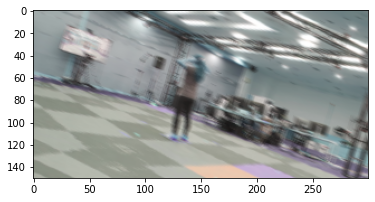

In [209]:
# train 데이터 확인
plt.imshow(np.array(train_image).transpose(1,2,0))

In [109]:
filename, test_img = test_data.__getitem__(0)

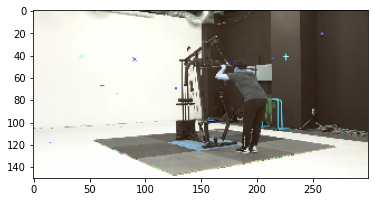

In [110]:
plt.imshow(np.array(test_img).transpose(1,2,0))

In [105]:
def get_model() -> nn.Module:
    backbone = resnet_fpn_backbone('resnet101', pretrained=True)
    roi_pooler = MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3'],
        output_size=7,
        sampling_ratio=2
    )

    keypoint_roi_pooler = MultiScaleRoIAlign(
        featmap_names=['0', '1', '2', '3'],
        output_size=14,
        sampling_ratio=2
    )

    model = KeypointRCNN(
        backbone, 
        num_classes=2,
        num_keypoints=24,
        box_roi_pool=roi_pooler,
        keypoint_roi_pool=keypoint_roi_pooler
    )

    return model

In [215]:
# loss and optim
model = get_model()
model.cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
#optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=5e-4)
#patience만큼 loss가 향상되지 않으면 learning_rate에 factor을 곱해줌 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor = 0.1, patience = 1, verbose=True)

In [33]:
model(images,targets)['loss_keypoint']

RuntimeError: ignored

In [216]:
for epoch in range(num_epochs):
    model.train()
    losses = []

    loop = tqdm(train_loader)
    for i, (images, targets) in enumerate(loop):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        #loss = criterion(model(images), targets)
        #losses = model(images, targets)
        #loss = sum(loss for loss in losses.values())
        loss = model(images,targets)['loss_keypoint']
        losses.append(loss)
        loss.backward()
        optimizer.step()

        if (i+1) % 10 == 0:
            print(f'| epoch: {epoch} | loss: {loss.item():.4f}')
            print()
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)


RuntimeError: ignored

In [36]:
model.eval()
pred = model(inputs.to(device))

In [87]:
pred[0]['keypoints_scores']

tensor([[2.7051, 2.7298, 2.6749, 2.4473, 2.7598, 3.0804, 3.2429, 2.3554, 2.0434,
         2.6088, 1.7458, 6.8053, 7.4754, 3.3857, 4.6913, 2.3058, 2.4519, 4.6812,
         2.3329, 2.2680, 7.3670, 8.4153, 1.3140, 1.4775],
        [2.7305, 2.6902, 2.2186, 2.1767, 2.5404, 3.4265, 3.2892, 2.2181, 2.5896,
         1.6263, 1.6364, 7.1059, 7.9154, 2.2918, 4.5007, 1.8647, 2.7834, 4.6465,
         2.1662, 1.6665, 7.8202, 7.9875, 2.0343, 2.2480],
        [2.9590, 3.0563, 2.1776, 2.2301, 2.6945, 4.0027, 3.4148, 2.0994, 2.5217,
         2.0948, 1.4896, 6.4010, 5.7757, 2.6738, 3.0984, 1.8738, 2.5853, 5.2733,
         1.9110, 2.0992, 7.2220, 7.0897, 1.4654, 1.5968],
        [3.6486, 1.5713, 2.7012, 1.9345, 2.0770, 2.6281, 2.4800, 1.3951, 1.9378,
         1.7133, 2.0092, 6.7987, 7.0293, 2.9051, 3.5813, 2.3929, 2.6949, 3.7737,
         2.8220, 2.2891, 4.5232, 7.0777, 1.5556, 1.4750],
        [3.1058, 1.9764, 2.6765, 2.7493, 2.5923, 2.6681, 2.9819, 1.2705, 2.2126,
         1.3564, 1.7837, 7.1844, 7.0364

In [83]:
pred[0]['keypoints']  [40,24,3] -> [24,2] ?

tensor([[[185.2454,  64.9514,   1.0000],
         [189.7443,  55.5038,   1.0000],
         [185.2454,  55.5038,   1.0000],
         ...,
         [189.7443,  73.2742,   1.0000],
         [194.2433, 131.5340,   1.0000],
         [200.0919, 131.5340,   1.0000]],

        [[191.6950,  54.8368,   1.0000],
         [186.0897,  48.5566,   1.0000],
         [184.2961,  48.5566,   1.0000],
         ...,
         [197.0761,  71.6585,   1.0000],
         [195.2824,  99.4706,   1.0000],
         [187.8834,  99.4706,   1.0000]],

        [[177.5935,  58.0109,   1.0000],
         [177.5935,  54.6360,   1.0000],
         [174.4489,  48.3360,   1.0000],
         ...,
         [179.8396,  69.7108,   1.0000],
         [186.5781, 118.7602,   1.0000],
         [180.7381, 118.7602,   1.0000]],

        ...,

        [[162.7015,  27.3337,   1.0000],
         [174.1676,  27.3337,   1.0000],
         [153.9333,  27.3337,   1.0000],
         ...,
         [168.5470,  46.1988,   1.0000],
         [188.5565,  6

In [81]:
pred[0]['keypoints'].shape , pred[1]['keypoints'].shape , pred[2]['keypoints'].shape , pred[3]['keypoints'].shape

(torch.Size([40, 24, 3]),
 torch.Size([7, 24, 3]),
 torch.Size([2, 24, 3]),
 torch.Size([61, 24, 3]))

In [ ]:
key = pred[0]['keypoints'][0][:,:2]
key = pred[1]['keypoints'][0][:,:2]
key = pred[2]['keypoints'][0][:,:2]
key.reshape(-1).detach().cpu().numpy()

array([160.66547 ,  54.27633 , 195.93826 ,  64.15483 , 173.92085 ,
        43.7243  , 171.67418 ,  70.21664 , 178.4142  ,  62.358738,
       180.66087 ,  64.37934 , 173.69618 ,  72.012726, 189.4229  ,
        68.19603 , 191.44492 ,  58.31754 , 173.92085 ,  54.27633 ,
       191.66957 ,  56.296932, 204.92494 ,  76.50295 , 164.93416 ,
        52.25573 , 169.65218 ,  25.987907, 167.4055  ,  72.237236,
       184.92955 ,  44.17332 , 187.17624 ,  64.37934 , 182.90755 ,
        58.31754 , 195.93826 ,  70.21664 , 165.15883 ,  54.27633 ,
       187.17624 ,  68.19603 , 193.91624 ,  60.33814 , 175.94286 ,
        66.17543 , 160.66547 ,  58.31754 ], dtype=float32)

In [48]:
#추론
model.eval()
print("eval")
all_predictions = []
files = []
with torch.no_grad():
  loop = tqdm(test_loader)
  for filenames, inputs in loop:
    pred = model(inputs.to(device))
    predictions = [[x['keypoints'][0][:,:2].reshape(-1).detach().cpu().numpy() for x in pred ],
                   [x['keypoints'][1][:,:2].reshape(-1).detach().cpu().numpy() for x in pred ],
                   [x['keypoints'][2][:,:2].reshape(-1).detach().cpu().numpy() for x in pred ],
                   [x['keypoints'][3][:,:2].reshape(-1).detach().cpu().numpy() for x in pred ]]
    #for i in range(1,batch_size):
    #  predictions.append([x['keypoints'][i][:,:2].reshape(-1).detach().cpu().numpy() for x in pred ])
    files.extend(filenames)
    for prediction in predictions:
      all_predictions.append(prediction)

eval


IndexError: ignored

In [32]:
all_predictions = np.array(all_predictions)
for i in range(all_predictions.shape[0]):
    all_predictions[i, [2*j for j in range(48//2)]] /= 300 / 1920
    all_predictions[i, [2*j + 1 for j in range(48//2)]] /= 150 / 1080

In [ ]:
df_sub = pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv')
df = pd.DataFrame(columns=df_sub.columns)
df['image'] = files
df.iloc[:, 1:] = all_predictions
df.head()

In [ ]:
df.to_csv('sub.csv', index=False)

In [75]:
inputs.shape

torch.Size([4, 3, 150, 300])

In [90]:
loss.item()

6.821656703948975